In [3]:
#Dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
import time

from envs import OfflineEnv
from recommender import DRRAgent

import os

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/ml-1m')
STATE_SIZE = 10

#  Check Data

In [4]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'movies.dat'),encoding='latin-1').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [5]:
# moive id to movie title
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [6]:
# number of movies
len(movies_list)

3883

In [7]:
# check the ratings
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


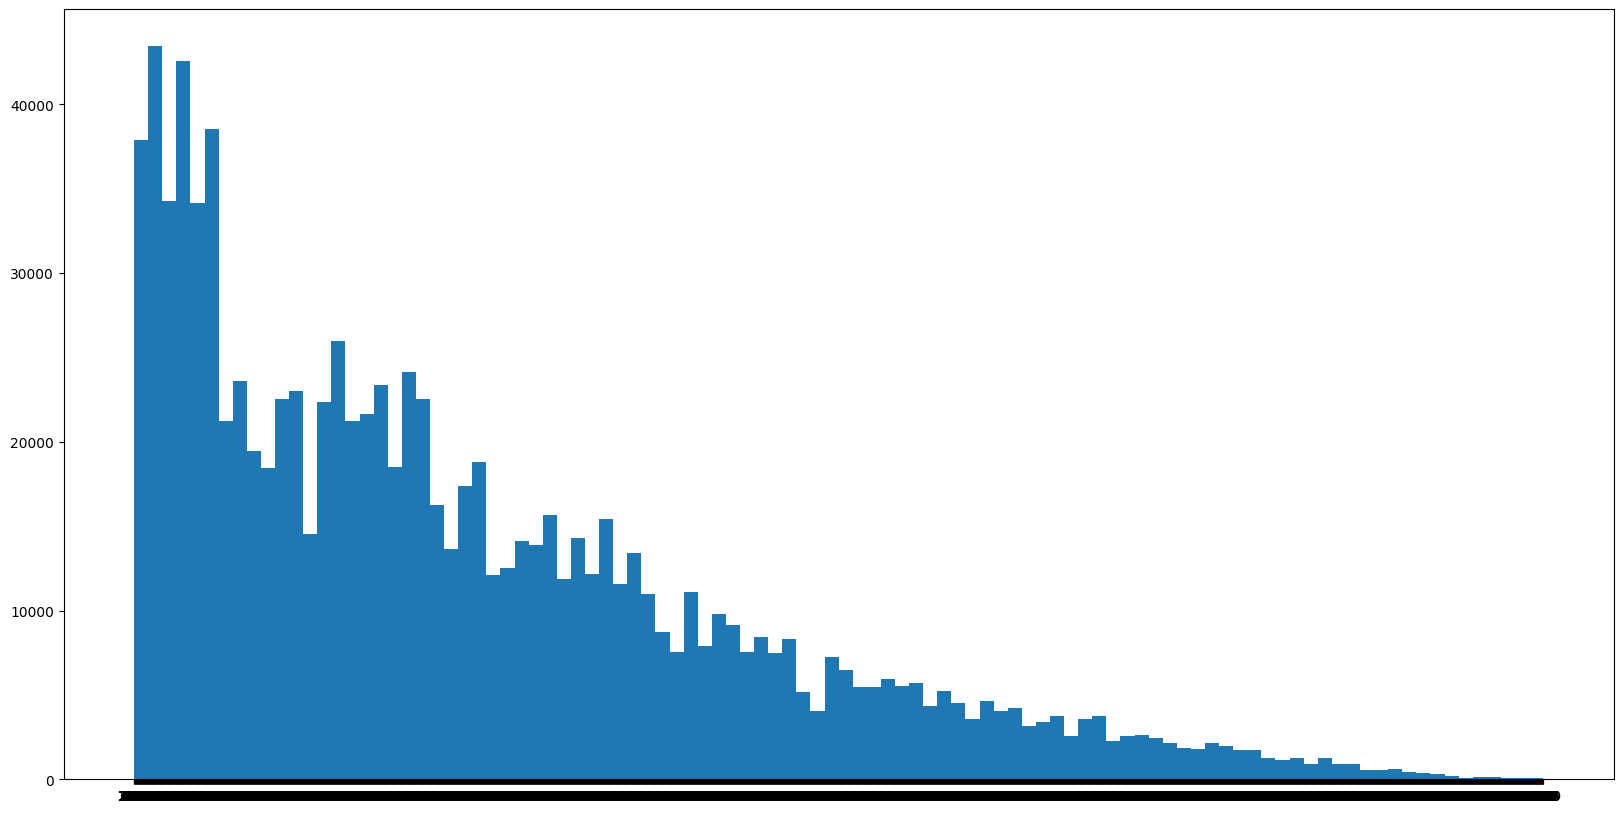

In [8]:
# check the distribution of movies choosen by user
plt.figure(figsize=(20,10))
plt.hist(ratings_df["MovieID"], bins=100)
plt.show()

In [9]:
# check null
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [10]:
# check the maximum value of UserID
print(len(set(ratings_df["UserID"])) == max([int(i) for i in set(ratings_df["UserID"])]))
print(max([int(i) for i in set(ratings_df["UserID"])]))

True
6040


In [11]:
# make suer the ratings are integer
ratings_df = ratings_df.applymap(int)

C:\Users\cindy\AppData\Local\Temp\ipykernel_50356\3532176190.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ratings_df = ratings_df.applymap(int)


In [12]:
# 유저별로 본 영화들 순서대로 정리
# make the user dictionary which have a value as movies list the user watched
users_dict = {user : [] for user in set(ratings_df["UserID"])}
users_dict[1]

[]

In [13]:
# order the dataset by time
ratings_df = ratings_df.sort_values(by='Timestamp', ascending=True)
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
1000138,6040,858,4,956703932
1000153,6040,2384,4,956703954
999873,6040,593,5,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977


In [14]:
# add (movie, rating) pair to the user dictionary
## add movie rated >= 4 only
ratings_df_gen = ratings_df.iterrows()
users_dict_for_history_len = {user : [] for user in set(ratings_df["UserID"])}
for data in ratings_df_gen:
    users_dict[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))
    if data[1]['Rating'] >= 4:
        users_dict_for_history_len[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))

In [15]:
# the length of history for each user
users_history_lens = [len(users_dict_for_history_len[u]) for u in set(ratings_df["UserID"])]

In [16]:
# check the length of above list
len(users_history_lens)

6040

In [17]:
# check the user dictionary
users_dict[1][:10]

[(3186, 4),
 (1721, 4),
 (1270, 5),
 (1022, 5),
 (2340, 3),
 (1836, 5),
 (3408, 4),
 (1207, 4),
 (2804, 5),
 (260, 4)]

In [18]:
# save each data as npy to save time for future evaluation
np.save("./data/user_dict.npy", users_dict)
np.save("./data/users_histroy_len.npy", users_history_lens)

In [19]:
# get the number of users and items
users_num = max(ratings_df["UserID"])+1
items_num = max(ratings_df["MovieID"])+1

In [20]:
# check the following variables
print(users_num, items_num)

6041 3953


### setting for training dataset

In [21]:
train_users_num = int(users_num * 0.8)
train_items_num = items_num
print(train_users_num, train_items_num)

4832 3953


In [22]:
train_users_dict = {k:users_dict[k] for k in range(1, train_users_num+1)}
train_users_history_lens = users_history_lens[:train_users_num]
print(len(train_users_dict),len(train_users_history_lens))

4832 4832


### setting for evaluation dataset

In [23]:
eval_users_num = int(users_num * 0.2)
eval_items_num = items_num
print(eval_users_num, eval_items_num)

1208 3953


In [24]:
eval_users_dict = {k:users_dict[k] for k in range(users_num-eval_users_num, users_num)}
eval_users_history_lens = users_history_lens[-eval_users_num:]
print(len(eval_users_dict),len(eval_users_history_lens))

1208 1208


### the variables are ready
- users_dict
- users_history_len
- movies_id_to_movies
- users_num
- items_num

# Evalutation

In [25]:
def evaluate(recommender, env, check_movies = False, top_k=False):

    # episodic reward 리셋
    episode_reward = 0
    steps = 0
    mean_precision = 0
    mean_ndcg = 0
    # Environment 리셋
    user_id, items_ids, done = env.reset()
    if check_movies:
        print(f'user_id : {user_id}, rated_items_length:{len(env.user_items)}')
        print('history items : \n', np.array(env.get_items_names(items_ids)))

    while not done:

        # Observe current state & Find action
        ## Embedding 해주기
        user_eb = recommender.embedding_network.get_layer('user_embedding')(np.array(user_id))
        items_eb = recommender.embedding_network.get_layer('movie_embedding')(np.array(items_ids))
        ## SRM으로 state 출력
        state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(items_eb, axis=0)])
        ## Action(ranking score) 출력
        action = recommender.actor.network(state)
        ## Item 추천
        recommended_item = recommender.recommend_item(action, env.recommended_items, top_k=top_k)
        if check_movies:
            print(f'recommended items ids : {recommended_item}')
            print(f'recommened items : \n {np.array(env.get_items_names(recommended_item), dtype=object)}')
        # Calculate reward & observe new state (in env)
        ## Step
        next_items_ids, reward, done, _ = env.step(recommended_item, top_k=top_k)
        if top_k:
            correct_list = [1 if r > 0 else 0 for r in reward]
            # ndcg
            dcg, idcg = calculate_ndcg(correct_list, [1 for _ in range(len(reward))])
            mean_ndcg += dcg/idcg
            
            #precision
            correct_num = top_k-correct_list.count(0)
            mean_precision += correct_num/top_k
            
        reward = np.sum(reward)
        items_ids = next_items_ids
        episode_reward += reward
        steps += 1
        
        if check_movies:
            print(f'precision : {correct_num/top_k}, dcg : {dcg:0.3f}, idcg : {idcg:0.3f}, ndcg : {dcg/idcg:0.3f}, reward : {reward}')
            print()
        break
    
    if check_movies:
        print(f'precision : {mean_precision/steps}, ngcg : {mean_ndcg/steps}, episode_reward : {episode_reward}')
        print()
    
    return mean_precision/steps, mean_ndcg/steps

def calculate_ndcg(rel, irel):
    dcg = 0
    idcg = 0
    rel = [1 if r>0 else 0 for r in rel]
    for i, (r, ir) in enumerate(zip(rel, irel)):
        dcg += (r)/np.log2(i+2)
        idcg += (ir)/np.log2(i+2)
    return dcg, idcg

In [30]:
# get the saved model dir
saved_actor = './save_model/trail-2023-12-13-18/actor_50_fixed.h5'
saved_critic = './save_model/trail-2023-12-13-18/critic_50_fixed.h5'

In [31]:
tf.keras.backend.set_floatx('float64')

In [32]:
TOP_K = 25 # chose any k value as you want

sum_precision = 0
sum_ndcg = 0

end_evaluation = 10

for i, user_id in enumerate(eval_users_dict.keys()):
    env = OfflineEnv(eval_users_dict, users_history_lens, movies_id_to_movies, STATE_SIZE, fix_user_id=user_id)
    recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
    recommender.actor.build_networks()
    recommender.critic.build_networks()
    recommender.load_model(saved_actor, saved_critic)
    precision, ndcg = evaluate(recommender, env, check_movies=True, top_k=TOP_K) # if check movies is true, you can check the recommended movies
    sum_precision += precision
    sum_ndcg += ndcg
    
    if i > end_evaluation:
        break
    
print(f'precision@{TOP_K} : {sum_precision/len(eval_users_dict)}, ndcg@{TOP_K} : {sum_ndcg/len(eval_users_dict)}')

user_id : 4833, rated_items_length:81
history items : 
 [['Vacation (1983)' 'Comedy']
 ['Airplane II: The Sequel (1982)' 'Comedy']
 ['In the Heat of the Night (1967)' 'Drama|Mystery']
 ['Muppet Treasure Island (1996)' "Adventure|Children's|Comedy|Musical"]
 ['Braveheart (1995)' 'Action|Drama|War']
 ['Beauty and the Beast (1991)' "Animation|Children's|Musical"]
 ['Mad Max 2 (a.k.a. The Road Warrior) (1981)' 'Action|Sci-Fi']
 ['Silence of the Lambs, The (1991)' 'Drama|Thriller']
 ['Amadeus (1984)' 'Drama']
 ['Grapes of Wrath, The (1940)' 'Drama']]
recommended items ids : [ 750 1304 1259  924 2716 1278 2797 1265 2028 2858  919  457 3175  527
 2916 1580 1097 1197 2571 1210  589 1270 1198 1196  260]
recommened items : 
 [['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'
  'Sci-Fi|War']
 ['Butch Cassidy and the Sundance Kid (1969)' 'Action|Comedy|Western']
 ['Stand by Me (1986)' 'Adventure|Comedy|Drama']
 ['2001: A Space Odyssey (1968)' 'Drama|Mystery|Sci-Fi|Thri

In [34]:
TOP_K = 25  # Choose any k value as you want

sum_precision = 0
sum_ndcg = 0

for user_id in eval_users_dict.keys():
    env = OfflineEnv(eval_users_dict, users_history_lens, movies_id_to_movies, STATE_SIZE, fix_user_id=user_id)
    recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
    recommender.actor.build_networks()
    recommender.critic.build_networks()
    recommender.load_model(saved_actor, saved_critic)
    
    precision, ndcg = evaluate(recommender, env, check_movies=True, top_k=TOP_K)  # if check movies is true, you can check the recommended movies
    
    sum_precision += precision
    sum_ndcg += ndcg

# Calculate average precision and ndcg
average_precision = sum_precision / len(eval_users_dict)
average_ndcg = sum_ndcg / len(eval_users_dict)

user_id : 4833, rated_items_length:81
history items : 
 [['Vacation (1983)' 'Comedy']
 ['Airplane II: The Sequel (1982)' 'Comedy']
 ['In the Heat of the Night (1967)' 'Drama|Mystery']
 ['Muppet Treasure Island (1996)' "Adventure|Children's|Comedy|Musical"]
 ['Braveheart (1995)' 'Action|Drama|War']
 ['Beauty and the Beast (1991)' "Animation|Children's|Musical"]
 ['Mad Max 2 (a.k.a. The Road Warrior) (1981)' 'Action|Sci-Fi']
 ['Silence of the Lambs, The (1991)' 'Drama|Thriller']
 ['Amadeus (1984)' 'Drama']
 ['Grapes of Wrath, The (1940)' 'Drama']]
recommended items ids : [ 480 1304 1259  924 2716 1278 2797 1265 2028  919 3175 2858  457  527
 1580 2916 1097 1197 2571  589 1210 1270 1198 1196  260]
recommened items : 
 [['Jurassic Park (1993)' 'Action|Adventure|Sci-Fi']
 ['Butch Cassidy and the Sundance Kid (1969)' 'Action|Comedy|Western']
 ['Stand by Me (1986)' 'Adventure|Comedy|Drama']
 ['2001: A Space Odyssey (1968)' 'Drama|Mystery|Sci-Fi|Thriller']
 ['Ghostbusters (1984)' 'Comedy|Horro

In [35]:
print(f'Average precision@{TOP_K} : {average_precision}, Average ndcg@{TOP_K} : {average_ndcg}')


Average precision@25 : 0.27549668874172173, Average ndcg@25 : 0.26496395430629255
